# Facial Expression Recognition Project

## Library Installations and Imports

In [1]:
!pip install -U -q PyDrive
!apt-get -qq install -y graphviz && pip install -q pydot
!pip install -q keras


from google.colab import files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pydot

import tensorflow as tf
from tensorflow.python.client import device_lib

from keras.models import Sequential
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, Dense
from keras.layers import Activation, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, to_categorical
from keras import backend as K


Selecting previously unselected package fontconfig.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../01-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5ubuntu0.1_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5ubuntu0.1) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6.0-3_amd64.deb ...
Unpa

Setting up libltdl7:amd64 (2.4.6-2) ...
Setting up libxcb-shm0:amd64 (1.12-1ubuntu1) ...
Setting up libxpm4:amd64 (1:3.5.12-1) ...
Setting up libxt6:amd64 (1:1.1.5-1) ...
Setting up libthai-data (0.1.26-3) ...
Setting up libcdt5 (2.38.0-16ubuntu2) ...
Setting up fontconfig (2.11.94-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcgraph6 (2.38.0-16ubuntu2) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libgvpr2 (2.38.0-16ubuntu2) ...
Setting up libgd3:amd64 (2.2.5-3) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libthai0:amd64 (0.1.26-3) ...
Setting up libxmu6:amd64 (2:1.1.2-2) ...
Setting up libpango-1.0-0:amd64 (1.40.12-1) ...
Setting up libxaw7:amd64 (2:1.0.13-1) ...
Setting up libpangoft2-1.0-0:amd64 (1.40.12-1) ...
Setting up libpangocairo-1.0-0:amd64 (1.40.12-1) ...
Setting up libgvc6 (2.38.0-16ubuntu2) ...
Setting up graphviz (2.38.0-16ubuntu2) ...
Processing triggers for libc-bin (2.26-0ubuntu2

Using TensorFlow backend.


### Confirm Tensorflow and GPU Support

In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6458463337310068377, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288900404
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7677106190574175192
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Helper Functions

In [0]:
def uploadFiles():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  filenames = list(uploaded.keys())
  for f in filenames:
    data = str(uploaded[f], 'utf-8')
    file = open(f, 'w')
    file.write(data)
    file.close()

def pullImage(frame, index: int):
  """
  Takes in a pandas data frame object and an index and returns the 48 x 48 pixel
  matrix as well as the label for the type of emotion.
  """
  img = frame.loc[index]['pixels'].split(' ')
  img = np.array([np.int(i) for i in img])
  img.resize(48,48)
  label = np.uint8(frame.loc[index]['emotion'])
  
  return img, label

def splitImage_Labels(frame):
  """
  Takes in a pandas data frame object filled with pixel field and label field 
  and returns two numpy arrays; one for images and one for labels.
  """
  labels = np.empty(len(frame))
  images = np.empty((len(frame), 48, 48, 1))  # using channel last notation.
  
  for i in range(len(frame)):
    img, lbl = pullImage(frame, i)
    img = np.reshape(img, (48,48,1))
    images[i], labels[i] = img, lbl
    
  return images.astype(np.uint8), to_categorical(labels, 7).astype(np.uint8)



## Import FER2013 Dataset and Other Files

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fer2013 = drive.CreateFile({'id':'1Xdlvej7eXaVcfCf3CsQ1LcSFAiNx_63c'})

In [0]:
fer2013.GetContentFile('fer2013file.csv')

Save file as a pandas dataframe.

In [0]:
df = pd.read_csv('fer2013file.csv')

## Parse Data

Each image is a 48 x 48 grayscale photo.

The contents of pixel string are space-separated pixel values in row major order.

Emotional assignment convention:


*   0 = Angry
*   1 = Disgust
*   2 = Fear
*   3 = Happy
*   4 = Sad
*   5 = Surprise
*   6 = Neutral


In [0]:
df_Training = df[df.Usage == 'Training']
df_Testing = df[df.Usage == 'PrivateTest'].reset_index(drop = True)
img_train, lbl_train = splitImage_Labels(df_Training)
img_test, lbl_test = splitImage_Labels(df_Testing)

In [11]:
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(img_train[0][0][0][0])) + '\t' + str(img_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(img_train[0][0][0][0])) + '\t' + 
      str(img_test.shape))
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(lbl_train[0][0])) + '\t' + str(lbl_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(lbl_train[0][0])) + '\t' + 
      str(lbl_test.shape))

Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 48, 48, 1)
	Testing: 	<class 'numpy.uint8'>	(3589, 48, 48, 1)
Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 7)
	Testing: 	<class 'numpy.uint8'>	(3589, 7)


### Save Data to .npy Files

In [0]:
#np.save('img_train.npy', img_train)
#np.save('lbl_train.npy', lbl_train)
#np.save('img_test.npy', img_test)
#np.save('lbl_test.npy', img_test)

### Verify Image Import

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

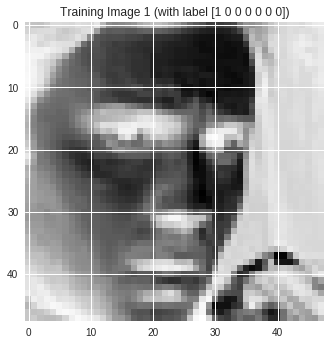

In [12]:
plt.imshow(np.reshape(img_train[0], (48,48)))
plt.title('Training Image 1 (with label ' + str(lbl_train[0]) + ')')

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

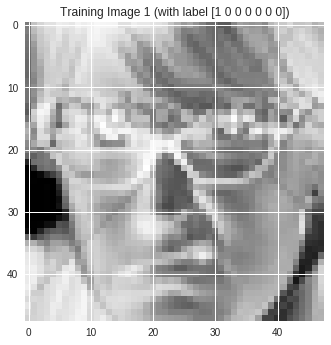

In [13]:
plt.imshow(np.reshape(img_test[0], (48,48)))
plt.title('Training Image 1 (with label ' + str(lbl_test[0]) + ')')

## Build Convolutional Neural Network Model


In [0]:
model = Sequential()

### Phase 1
- Convolutional and Max Pooling Phase.
- **Kernal Size: 5x5**
- **Ouput Filters: 40**
- **Stride: 1 (default)**
- **Active Padding**

In [0]:
outputFilters = 40
kernelSize = 5

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu',
                 input_shape=img_train[0].shape))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

### Phase 2
- Convolutional and Max Pooling Phase.
- **Kernal Size: 5x5**
- **Ouput Filters: 60**
- **Stride: 1 (default)**
- **Active Padding**


In [0]:
outputFilters = 60
kernelSize = 5 

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

### Phase 3
- Locally-Connected Convlutional Filtering Phase.
  - The locally-connected layer works similarly to the traditional 2D convolutional layer, except that weights are unshared, that is, a different set of filters is applied at each different patch of the input.
- **Ouput Filters: 100**
- **Kernal Size: 3x3**
- **Stride: 1 (default)**
- **Non-Active Padding**

In [0]:
outputFilters = 100
kernelSize = 3

model.add(LocallyConnected2D(outputFilters, kernelSize, padding='valid', activation='relu'))
model.add(LocallyConnected2D(outputFilters, kernelSize, padding='valid', activation='relu'))

### Dense Layers

In [43]:
layerSize = 64

model.add(Flatten())
model.add(Dense(layerSize, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(layerSize, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 40)        1040      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 40)        40040     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 40)        40040     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 40)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 60)        60060     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 60)        90060     
__________

## Compile, Train, and Evaluate the Model

In [44]:
batchSize = 200
trainingEpochs = 50

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

trainingHistory = model.fit(img_train, lbl_train, batch_size=batchSize, 
                            epochs=trainingEpochs,
                            validation_split=0.3, 
                            callbacks=[early_stopping], 
                            shuffle=True,)

trainingAccuracy = trainingHistory.history['acc']
validationAccuracy = trainingHistory.history['val_acc']
print("Done Training: ")
print('Final Training Accuracy: ', trainingAccuracy[-1])
print('Final Validation Accuracy: ', validationAccuracy[-1])
print('Overfit Ratio: ', validationAccuracy[-1]/trainingAccuracy[-1])

metrics = model.evaluate(img_test, lbl_test, batch_size=batchSize, verbose=1)
print('Evaluation Loss: ', metrics[0])
print('Evaluation Accuracy: ', metrics[1])

Train on 20096 samples, validate on 8613 samples
Epoch 1/50
20096/20096 [==============================] - 29s 1ms/step - loss: 1.9219 - acc: 0.2317 - val_loss: 1.8137 - val_acc: 0.2529
Epoch 2/50
20096/20096 [==============================] - 27s 1ms/step - loss: 1.8001 - acc: 0.2595 - val_loss: 1.7060 - val_acc: 0.3193
Epoch 3/50
20096/20096 [==============================] - 27s 1ms/step - loss: 1.7166 - acc: 0.2998 - val_loss: 1.6264 - val_acc: 0.3560
Epoch 4/50
 4800/20096 [======>.......................] - ETA: 18s - loss: 1.6531 - acc: 0.3335

20096/20096 [==============================] - 27s 1ms/step - loss: 1.6384 - acc: 0.3433 - val_loss: 1.5926 - val_acc: 0.3756
Epoch 5/50
20096/20096 [==============================] - 27s 1ms/step - loss: 1.5620 - acc: 0.3793 - val_loss: 1.5275 - val_acc: 0.4018
Epoch 6/50
20096/20096 [==============================] - 27s 1ms/step - loss: 1.5022 - acc: 0.3981 - val_loss: 1.4832 - val_acc: 0.4353
Epoch 7/50
13600/20096 [===================>..........] - ETA: 7s - loss: 1.4476 - acc: 0.4220

20096/20096 [==============================] - 27s 1ms/step - loss: 1.4459 - acc: 0.4221 - val_loss: 1.4475 - val_acc: 0.4445
Epoch 8/50
20096/20096 [==============================] - 27s 1ms/step - loss: 1.3787 - acc: 0.4510 - val_loss: 1.4516 - val_acc: 0.4578
Epoch 9/50
20096/20096 [==============================] - 27s 1ms/step - loss: 1.3327 - acc: 0.4690 - val_loss: 1.3968 - val_acc: 0.4689
Epoch 10/50
15200/20096 [=====================>........] - ETA: 5s - loss: 1.2654 - acc: 0.4971

20096/20096 [==============================] - 27s 1ms/step - loss: 1.2703 - acc: 0.4969 - val_loss: 1.4492 - val_acc: 0.4856
Epoch 11/50
20096/20096 [==============================] - 27s 1ms/step - loss: 1.2318 - acc: 0.5121 - val_loss: 1.4186 - val_acc: 0.4963
Epoch 12/50
20096/20096 [==============================] - 27s 1ms/step - loss: 1.1483 - acc: 0.5464 - val_loss: 1.3899 - val_acc: 0.4994
Epoch 13/50
15200/20096 [=====================>........] - ETA: 5s - loss: 1.0800 - acc: 0.5714

20096/20096 [==============================] - 27s 1ms/step - loss: 1.0767 - acc: 0.5744 - val_loss: 1.4243 - val_acc: 0.5157
Epoch 14/50
20096/20096 [==============================] - 27s 1ms/step - loss: 0.9962 - acc: 0.6104 - val_loss: 1.4531 - val_acc: 0.5280
Epoch 15/50
20096/20096 [==============================] - 27s 1ms/step - loss: 0.9303 - acc: 0.6380 - val_loss: 1.4858 - val_acc: 0.5381
Epoch 16/50
15200/20096 [=====================>........] - ETA: 5s - loss: 0.8613 - acc: 0.6674

20096/20096 [==============================] - 27s 1ms/step - loss: 0.8625 - acc: 0.6659 - val_loss: 1.5306 - val_acc: 0.5366
Epoch 17/50
20096/20096 [==============================] - 27s 1ms/step - loss: 0.7971 - acc: 0.6948 - val_loss: 1.5623 - val_acc: 0.5368
Epoch 00017: early stopping
Done Training: 
Final Training Accuracy:  0.6948148870401701
Final Validation Accuracy:  0.5368373401831019
Overfit Ratio:  0.7726336182
3589/3589 [==============================] - 1s 357us/step
Evaluation Accuracy:  0.53258567856161266


## Predictions

In [0]:
def predict(mdl, img):
  emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
  im = np.zeros((1, 48, 48, 1))
  im[0] = img
  p = mdl.predict(im)

  i = np.argmax(p)
  
  plt.imshow(np.reshape(img, (48,48)))
  plt.title('Test Image (Predicted Label: ' + emotions[i] + ')')
  return p

array([[0.13312052, 0.00454683, 0.09957016, 0.00821611, 0.3444841 ,
        0.00446442, 0.4055979 ]], dtype=float32)

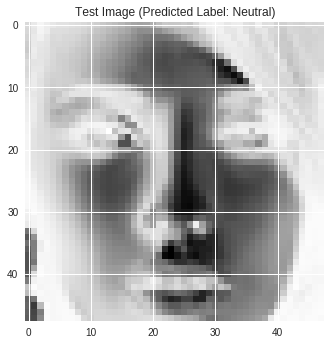

In [277]:
predict(model, img_test[12])

## Intermediate Layer Output

In [0]:
layer0 = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[0].output])
layer1 = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[1].output])
layer3 = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[3].output])
layer7 = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[7].output])

- Image being used for this example:

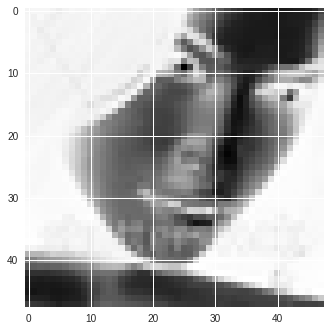

In [118]:
im = np.zeros((1, 48, 48, 1))
im[0] = img_test[21]
plt.imshow(np.reshape(img_test[21], (48,48)))

### Layer 0 (after first convolution)

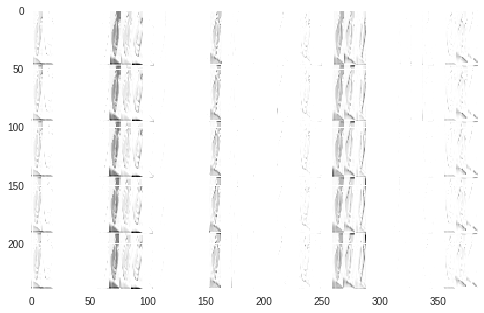

In [196]:
layer_output = layer0([im, 0])[0]
ALL = layer_output[0,:,:,:]
ALL = np.reshape(ALL, (48*5, 48 * 8), order='F')

plt.imshow(ALL)

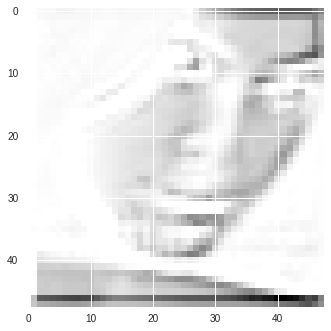

In [199]:
plt.imshow(layer_output[0, :, :,0])

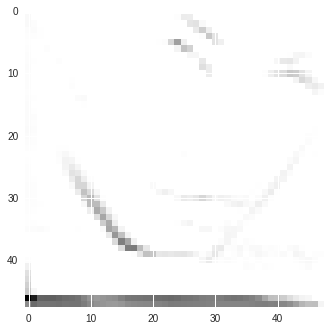

In [200]:
plt.imshow(layer_output[0, :, :,1])

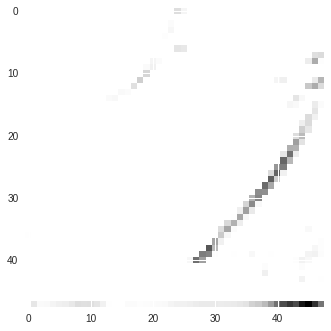

In [201]:
plt.imshow(layer_output[0, :, :,6])

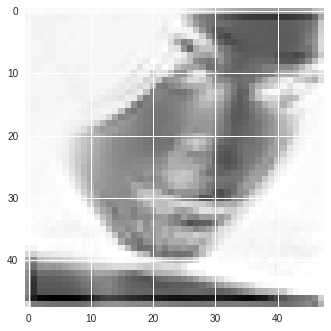

In [202]:
plt.imshow(layer_output[0, :, :,7])

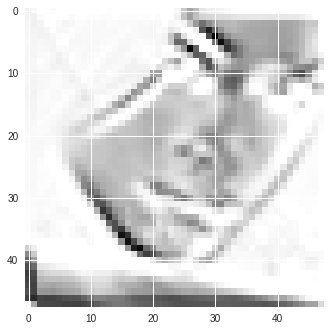

In [203]:
plt.imshow(layer_output[0, :, :,8])

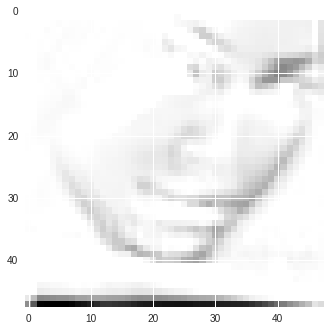

In [205]:
plt.imshow(layer_output[0, :, :,9])

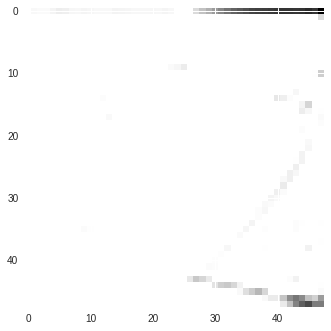

In [206]:
plt.imshow(layer_output[0, :, :,10])

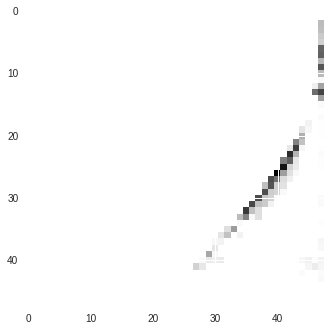

In [207]:
plt.imshow(layer_output[0, :, :,11])

### Layer 1 (after second convolution)

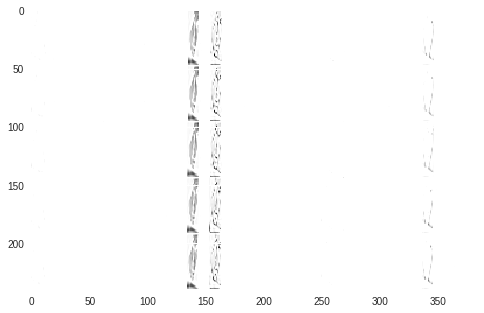

In [225]:
layer_output = layer1([im, 0])[0]
ALL = layer_output[0,:,:,:]
ALL = np.reshape(ALL, (48*5, 48 * 8), order='F')

plt.imshow(ALL)

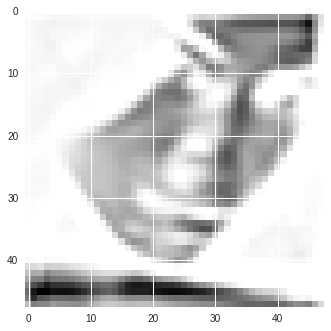

In [226]:
plt.imshow(layer_output[0, :, :,14])

### Layer 3 (after first pooling)

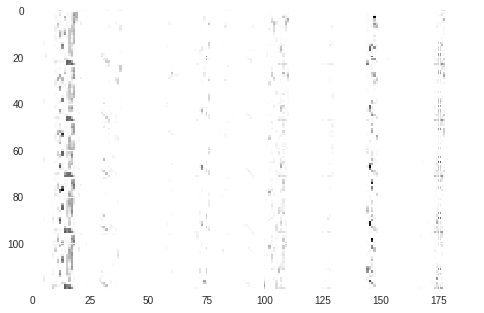

In [243]:
layer_output = layer3([im, 0])[0]
ALL = layer_output[0,:,:,:]
ALL = np.reshape(ALL, (24*5, 24 * 8), order='F')

plt.imshow(ALL)

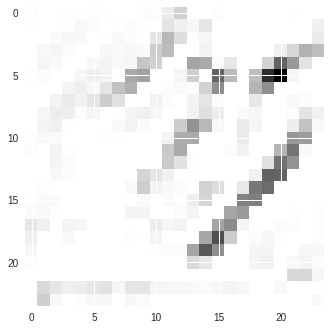

In [244]:
plt.imshow(layer_output[0, :, :,2])

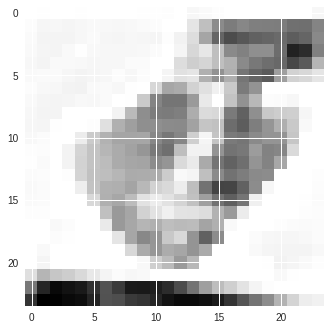

In [245]:
plt.imshow(layer_output[0, :, :,3])

### Layer 7 (after second pooling)

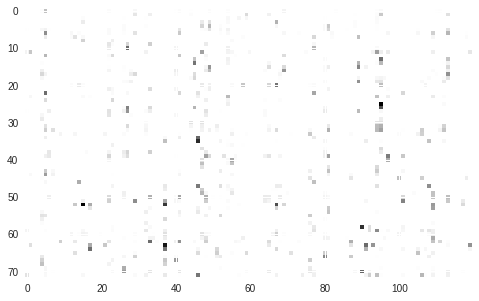

In [247]:
layer_output = layer7([im, 0])[0]
ALL = layer_output[0,:,:,:]
ALL = np.reshape(ALL, (12*6, 12 * 10), order='F')

plt.imshow(ALL)

## Look at the Weights

In [0]:
weights = model.get_weights()

### Layer 0 

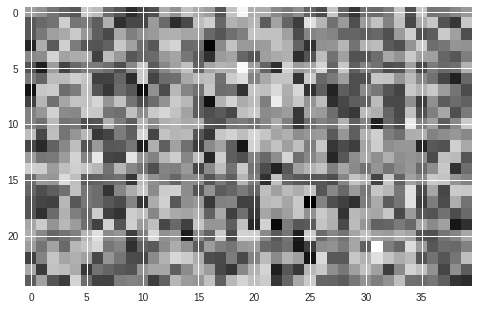

In [262]:
w0 = weights[0]
w0 = w0[:,:,0,:]
ALL = np.reshape(w0, (5*5, 5 * 8), order='F')

plt.imshow(ALL)